In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import random
from scipy import stats
from sklearn import neighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

C:\Users\Pc\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("heart.csv")
data.head(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [3]:
# 1. feature selection with variance threshold
selector = VarianceThreshold(threshold=0.7)
selector.fit(data)
mask = selector.get_support()
selected_features = data.columns[mask].tolist()
selected_features
#new_data = data[selected_features]
#new_data

['age', 'cp', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'caa']

In [4]:
X=data.drop('output',axis=1)
y=data['output']

In [10]:
# 2. forward feature selection
estimator = LinearRegression()
fselector = SequentialFeatureSelector(estimator, forward=True, k_features=5, scoring='r2', cv=5)
# Fit the selector to the dataset
fselector.fit(X, y)
selected_features_forward = fselector.k_feature_names_
selected_features_forward = list(selected_features_forward)
selected_features_forward

['sex', 'restecg', 'exng', 'oldpeak', 'thall']

In [11]:
# 3. Backward feature selecton
estimator = LinearRegression()
bselector = SequentialFeatureSelector(estimator, forward=False, k_features=5, scoring='r2', cv=5)
bselector.fit(X, y)
selected_features_backward = fselector.k_feature_names_
selected_features_backward = list(selected_features_backward)
selected_features_backward

['sex', 'restecg', 'exng', 'oldpeak', 'thall']

In [12]:
# 4. Recursive feature selection
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=5, step=5, verbose=10)
selector.fit(X, y)
rfe_support = selector.get_support()
recursive_feature = X.loc[:,rfe_support].columns.tolist()
recursive_feature

Fitting estimator with 13 features.
Fitting estimator with 8 features.


['sex', 'cp', 'exng', 'caa', 'thall']

In [13]:
# 5. Lasso feature selection
estimator = LassoCV(cv=5)
sfm = SelectFromModel(estimator, prefit=False, norm_order=1, max_features=None)
sfm.fit(X, y)
feature_idx = sfm.get_support()
Lasso_features = X.columns[feature_idx].tolist()
Lasso_features

['age',
 'sex',
 'cp',
 'trtbps',
 'chol',
 'restecg',
 'thalachh',
 'exng',
 'oldpeak',
 'slp',
 'caa',
 'thall']

['cp', 'caa', 'thall', 'oldpeak', 'chol', 'age', 'thalachh']

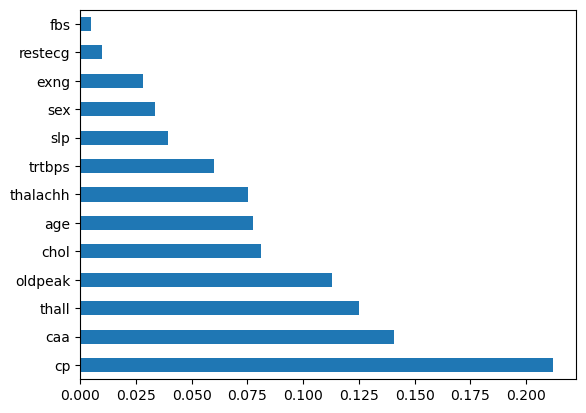

In [14]:
# 6. feature importances feature selection
np.random.seed(10)
model = RandomForestRegressor(random_state = random.seed(10))
model.fit(X, y)
features = X
importances = model.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
rf_top_features = pd.DataFrame(feat_importances.nlargest(7)).axes[0].tolist()
rf_top_features

In [15]:
#. 7. Select the top n features based on absolute correlation with target variable
corr_data1 = pd.concat([y,X],axis = 1)
corr_data = corr_data1.corr()
corr_data = corr_data.iloc[: , [0]]
corr_data.columns.values[0] = "Correlation"
corr_data = corr_data.iloc[corr_data.Correlation.abs().argsort()] 
corr_data = corr_data[corr_data['Correlation'].notna()]
corr_data = corr_data.loc[corr_data['Correlation'] != 1]
corr_data2 = corr_data.loc[corr_data['Correlation'].abs() > .4]
corr_top_features = corr_data2.axes[0].tolist()
corr_top_features
corr_data

,Correlation
fbs,-0.028046
chol,-0.085239
restecg,0.137230
trtbps,-0.144931
age,-0.225439
sex,-0.280937
thall,-0.344029
slp,0.345877
caa,-0.391724
thalachh,0.421741


In [16]:
# Combining features from all the models

combined_feature_list = selected_features + selected_features_forward + selected_features_backward + recursive_feature + Lasso_features + corr_top_features + rf_top_features

combined_feature = {x:combined_feature_list.count(x) for x in combined_feature_list}
combined_feature_data = pd.DataFrame.from_dict(combined_feature,orient='index')
combined_feature_data.rename(columns={ combined_feature_data.columns[0]: "number_of_models" }, inplace = True)
combined_feature_data = combined_feature_data.sort_values(['number_of_models'], ascending=[False])
combined_feature_data.head(100)

,number_of_models
oldpeak,6
cp,5
exng,5
thall,5
thalachh,4
caa,4
sex,4
age,3
chol,3
restecg,3
